In [1]:
### Run environment setup
import os
import lib.BBSetup as BBSetup

try:
    from google.colab import drive
    BBSetup.colab_setup(mount_folder=r"/content/drive/My Drive/unibo/NLP_project/BarneyBot")
except:
    try:
        BBSetup.anaconda_setup(base_folder=r"C:\Users\User\Documents\Unibo\NLP\BarneyBot",
                            env_name="nlp")
    except:
        print("Impossible to setup anaconda")

### Define folders
base_folder = BBSetup.BASE_FOLDER
print(base_folder)
out_folder = BBSetup.set_folder(os.path.join(base_folder, 'Metrics', 'New'))

pip install -r "C:\Users\User\Documents\Unibo\NLP\BarneyBot\requirements.txt"
Impossible to setup anaconda
C:\Users\User\Documents\Unibo\NLP\BarneyBot


In [2]:
from functools import partial
from os.path import join, exists
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
#
from sklearn.metrics import classification_report as sklcls_report
from sklearn.metrics import f1_score, accuracy_score
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, TFAutoModelForCausalLM
#
from transformers import logging
logging.set_verbosity_info()
# only report errors
logging.set_verbosity(logging.CRITICAL)
#
# Import the metrics library
from lib.BBMetrics import BBMetric
# Pretty print module
import pprint
from lib.BBMetricResults import *
printer = pprint.PrettyPrinter(depth=4, width=300)
# Import project data
from lib.BBData import character_dict, model_name, random_state
from lib.BBDataLoad import dialogpt_preprocess_function, load_char_df, get_chatbot_predictions, merge_df_for_metrics

c:\Users\User\Documents\Unibo\NLP\BarneyBot\.env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
characters_folder = join(base_folder, "Data", "Characters")
print(characters_folder)
characters = list(character_dict.keys())
classification_report = partial(sklcls_report, target_names=characters)

C:\Users\User\Documents\Unibo\NLP\BarneyBot\Data\Characters


In [4]:

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=join("..", "cache"))
tokenizer.pad_token = '#'
data_collator = DataCollatorForLanguageModeling(mlm=False, tokenizer=tokenizer, return_tensors='tf')
# 
characters_noDefault = characters.copy()
characters_noDefault.remove('Default')

In [5]:
metric = BBMetric.load_metric("frequency chatbot classifier")
print(metric)

{'name': 'frequency chatbot classifier', 'args': {'train': {'required': {'characters_path'}, 'optional': {'mode'}}, 'compute': {'required': {'sentences'}, 'optional': set()}}, 'returns': ['score', 'label'], 'description': None, 'paper': None, 'save_actors': ['document']}


In [6]:
metric.train(characters_path=os.path.join(base_folder, "Data","Characters"))

Loading data


100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


Preprocessing data


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Training model
Training done!


In [7]:
### create dataset
n_tests = 3
max_test_size = 40
selected_indeces = [range(i+1) for i in range(max_test_size)]
doc_test = []
batch_size = 8
override_predictions = True
character = 'Barney'
character_checkpoint = join(characters_folder, character, character_dict[character]['checkpoint_folder'])
print("model loading")
model_chatbot = TFAutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=character_checkpoint) if override_predictions else None
print("model loaded")

character_hg = load_char_df(character, base_folder)
# This transform in a sequence of tokens ours dataset
tokenized_character_hg = character_hg.map(lambda row: dialogpt_preprocess_function(row, tokenizer), batched=False)

# Define tensorflow datasets
encoded_test_set = tokenized_character_hg["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

chatbot_senteces = []
raw_predictions = []
test_run = {character: [{"n_sentences": t,
                         "chatbot_senteces": [],
                         "raw_predictions": []} for t in range(n_tests*max_test_size)]}

if n_tests > 1 and not override_predictions:
    raise Exception('must override previous predictions if you need more tests')

predictions_file = join(base_folder, 'src', 'tmp', character+'_predictions_cTFIDF.json')
if not(override_predictions) or exists(predictions_file):
    with open(predictions_file, 'r', encoding='utf-8') as file:
        test_run = json.load(file)
else:
    # n_test = 20, max_test_size = 20 -> 287'
    for t in range(n_tests):
        print(f'Run {t}/{n_tests}')
        for j in range(max_test_size):
            character_hg['test'].shuffle(random_state)
            tmp_hg = character_hg.copy()
            # Takes a subset of the testset as sample question
            tmp_hg['test'] = tmp_hg['test'].select(selected_indeces[j])
            sample_questions = tmp_hg['test']['context/0']
            # Sampling generation method
            predictions_sampling = get_chatbot_predictions(
                sample_questions,
                model_chatbot,
                character_dict[character]['prediction_filename'] + '_sampling.json',
                "Sampling",
                character,
                tokenizer,
                base_folder,
                override_predictions=override_predictions
            )
            sentences = merge_df_for_metrics(tmp_hg['test'], None, None, predictions_sampling, tokenizer)['prd_sampling'].tolist()
            test_run[character][t*max_test_size+j]["n_sentences"] = t
            test_run[character][t*max_test_size+j]["chatbot_senteces"] = sentences
            test_run[character][t*max_test_size+j]["raw_predictions"] = list(metric.compute(sentences=sentences)['score'])

model loading
model loaded


Using custom data configuration default-d78476db32c8db98
Found cached dataset csv (c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 306.78it/s]
Loading cached split indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-312847c31a279b58.arrow and c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-3e6545d8f1f160fe.arrow
Loading cached split indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-9cde59f05c14ff78.arrow and c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d784

Run 0/3
Creating predictions


100%|██████████| 1/1 [00:00<00:00, 568.56it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 2/2 [00:00<00:00, 664.81it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 3/3 [00:00<00:00, 710.34it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 4/4 [00:00<00:00, 867.26it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 5/5 [00:00<00:00, 993.11it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 6/6 [00:00<00:00, 1200.77it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 7/7 [00:00<00:00, 1172.95it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 8/8 [00:00<00:00, 995.92it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 9/9 [00:00<00:00, 983.35it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 10/10 [00:00<00:00, 1111.02it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 11/11 [00:00<00:00, 1222.51it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 12/12 [00:00<00:00, 1021.05it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 13/13 [00:00<00:00, 983.32it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 14/14 [00:00<00:00, 1248.12it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 15/15 [00:00<00:00, 1069.03it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 16/16 [00:00<00:00, 1227.80it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 17/17 [00:00<00:00, 1062.09it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 18/18 [00:00<00:00, 1064.35it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 19/19 [00:00<00:00, 1059.79it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 20/20 [00:00<00:00, 1111.12it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 21/21 [00:00<00:00, 1017.80it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 22/22 [00:00<00:00, 1157.91it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 23/23 [00:00<00:00, 1148.28it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 24/24 [00:00<00:00, 1199.80it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 25/25 [00:00<00:00, 1248.02it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 26/26 [00:00<00:00, 1136.70it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 27/27 [00:00<00:00, 809.80it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 28/28 [00:00<00:00, 903.12it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 29/29 [00:00<00:00, 935.65it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 30/30 [00:00<00:00, 1248.89it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 31/31 [00:00<00:00, 1007.65it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 32/32 [00:00<00:00, 1141.04it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 33/33 [00:00<00:00, 1010.87it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 34/34 [00:00<00:00, 1029.35it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 35/35 [00:00<00:00, 1026.96it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 36/36 [00:00<00:00, 1065.00it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 37/37 [00:00<00:00, 980.37it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 38/38 [00:00<00:00, 1057.79it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 39/39 [00:00<00:00, 1128.16it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 40/40 [00:00<00:00, 1120.18it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Run 1/3
Creating predictions


100%|██████████| 1/1 [00:00<00:00, 485.73it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 2/2 [00:00<00:00, 512.28it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 3/3 [00:00<00:00, 744.51it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 4/4 [00:00<00:00, 992.15it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 5/5 [00:00<00:00, 855.91it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 6/6 [00:00<00:00, 1012.87it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 7/7 [00:00<00:00, 583.28it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 8/8 [00:00<00:00, 800.02it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 9/9 [00:00<00:00, 860.55it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 10/10 [00:00<00:00, 357.74it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 11/11 [00:00<00:00, 916.41it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 12/12 [00:00<00:00, 665.63it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 13/13 [00:00<00:00, 810.76it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 14/14 [00:00<00:00, 735.67it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 15/15 [00:00<00:00, 681.83it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 16/16 [00:00<00:00, 800.77it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 17/17 [00:00<00:00, 913.02it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 18/18 [00:00<00:00, 999.69it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 19/19 [00:00<00:00, 702.95it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 20/20 [00:00<00:00, 868.55it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 21/21 [00:00<00:00, 583.91it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 22/22 [00:00<00:00, 759.47it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 23/23 [00:00<00:00, 622.14it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 24/24 [00:00<00:00, 913.70it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 25/25 [00:00<00:00, 756.23it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 26/26 [00:00<00:00, 841.38it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 27/27 [00:00<00:00, 931.16it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 28/28 [00:00<00:00, 848.41it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 29/29 [00:00<00:00, 949.56it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 30/30 [00:00<00:00, 966.93it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 31/31 [00:00<00:00, 570.77it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 32/32 [00:00<00:00, 1136.93it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 33/33 [00:00<00:00, 782.84it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 34/34 [00:00<00:00, 1134.19it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 35/35 [00:00<00:00, 1210.55it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 36/36 [00:00<00:00, 1154.59it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 37/37 [00:00<00:00, 1158.46it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 38/38 [00:00<00:00, 1235.84it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 39/39 [00:00<00:00, 511.72it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 40/40 [00:00<00:00, 1113.94it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Run 2/3
Creating predictions


100%|██████████| 1/1 [00:00<00:00, 471.54it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 2/2 [00:00<00:00, 985.04it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 3/3 [00:00<00:00, 1063.37it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 4/4 [00:00<00:00, 1320.11it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 5/5 [00:00<00:00, 994.24it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 6/6 [00:00<00:00, 1193.09it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 7/7 [00:00<00:00, 995.56it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 8/8 [00:00<00:00, 1137.59it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 9/9 [00:00<00:00, 1000.05it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 10/10 [00:00<00:00, 1094.98it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 11/11 [00:00<00:00, 1217.60it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 12/12 [00:00<00:00, 1091.13it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 13/13 [00:00<00:00, 1122.56it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 14/14 [00:00<00:00, 1066.05it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 15/15 [00:00<00:00, 1156.48it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 16/16 [00:00<00:00, 1064.19it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 17/17 [00:00<00:00, 1185.17it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 18/18 [00:00<00:00, 1282.44it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 19/19 [00:00<00:00, 1053.72it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 20/20 [00:00<00:00, 1001.89it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 21/21 [00:00<00:00, 1164.65it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 22/22 [00:00<00:00, 1222.41it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 23/23 [00:00<00:00, 1097.62it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 24/24 [00:00<00:00, 1089.54it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 25/25 [00:00<00:00, 1043.10it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 26/26 [00:00<00:00, 1181.62it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 27/27 [00:00<00:00, 1123.31it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 28/28 [00:00<00:00, 978.09it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 29/29 [00:00<00:00, 1074.28it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 30/30 [00:00<00:00, 1141.13it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 31/31 [00:00<00:00, 1258.66it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 32/32 [00:00<00:00, 1292.83it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 33/33 [00:00<00:00, 840.98it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 34/34 [00:00<00:00, 1125.72it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 35/35 [00:00<00:00, 1126.10it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 36/36 [00:00<00:00, 1132.66it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 37/37 [00:00<00:00, 1192.31it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 38/38 [00:00<00:00, 1267.76it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 39/39 [00:00<00:00, 1083.30it/s]
Loading cached shuffled indices for dataset at c:/Users/User/Documents/Unibo/NLP/BarneyBot/src/cache/csv/default-d78476db32c8db98/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8dc459ec58312e18.arrow


Creating predictions


100%|██████████| 40/40 [00:00<00:00, 1266.33it/s]


In [8]:
y_pred = []
y_true = []
for t in range(max_test_size*n_tests):
    raw_predictions = test_run[character][t]["raw_predictions"]
    y_pred += [0 if np.argmax(raw_predictions) == 0 else 1]
    # y_true += [characters.index(character)]
    y_true += [0]
# labels = set(y_pred).union(set(y_true))
# labels = [characters[i] for i in labels]
# print(labels)
# confusion_matrix(y_true, y_pred,)
confusion_matrix(y_true, y_pred,normalize='true')

array([[0.825, 0.175],
       [0.   , 0.   ]])

In [22]:
n_tests

3

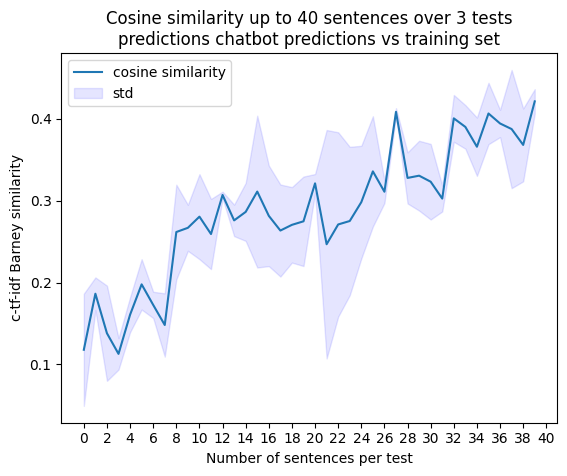

In [23]:
c_id = characters.index(character)
len_tests = len(test_run[character])
y = np.zeros(max_test_size)
x = np.arange(max_test_size)
std = np.zeros(max_test_size)
for i in range(max_test_size):
    y[i] = np.mean([test_run[character][t*max_test_size+i]['raw_predictions'][c_id]\
                    for t in range(n_tests)])
    std[i] = np.std([test_run[character][t*max_test_size+i]['raw_predictions'][c_id]\
                     for t in range(n_tests)])
fig, ax = plt.subplots()
ax.set_xlabel('Number of sentences per test')
ax.set_ylabel('c-tf-idf '+character+' similarity')
ax.set_title('Cosine similarity up to '+str(max_test_size)+' sentences over '+str(n_tests)+' tests\n\
predictions chatbot predictions vs training set')
ax.set_xticks([i for i in range(0,len(x)+1,2)])
ax.plot(x, y, label='cosine similarity')
ax.fill_between(x, (y-std), (y+std), color='b', alpha=.1, label='std')
ax.legend(loc='upper left')
plt.savefig(join(base_folder, 'src', 'tmp', character+'_cTFIDF.png'))
plt.show()

In [ ]:
# test_run1 = {"Barney": []}
# for t in range(n_tests):
#     for j in range(max_test_size):
#         test_t = test_run[t].copy()
#         chatbot_senteces_t = test_t['chatbot_senteces']
#         raw_predictions_t = test_t['raw_predictions']
#         index = t*n_tests+j
#         test_t['chatbot_senteces'] = chatbot_senteces_t[index]
#         test_t['raw_predictions'] = list(raw_predictions_t[index])
#         test_run1['Barney'].append(test_t) 

In [ ]:
predictions_file = join(base_folder, 'src', 'tmp', character+'_predictions_cTFIDF.json')
with open(predictions_file, 'w', encoding='utf-8') as file:
    json.dump(test_run, file)